In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

# Re-organize the data: train/test in DataLoaders

In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)

# Now for the DL part

In [5]:
# create a class for the model WITH BATCH NORM

class ANNwine_withBNorm(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(in_features=11, out_features=16)

        ### hidden layers
        self.fc1    = nn.Linear(in_features=16, out_features=32)
        self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer
        self.fc2    = nn.Linear(in_features=32, out_features=20)
        self.bnorm2 = nn.BatchNorm1d(32) # the number of units into this layer

        ### output layer
        self.output = nn.Linear(in_features=20, out_features=1)
  
    # forward pass
    def forward(self, x, doBN):

        # input (x starts off normalized)
        x = F.relu( self.input(x) )


        if doBN:
            # hidden layer 1
            x = self.bnorm1(x) # batchnorm
            x = self.fc1(x)    # weighted combination
            x = F.relu(x)      # activation function

            # hidden layer 2
            x = self.bnorm2(x) # batchnorm
            x = self.fc2(x)    # weighted combination
            x = F.relu(x)      # activation function
    

        else:
            # hidden layer 1
            x = F.relu( self.fc1(x) )

            # hidden layer 2
            x = F.relu( self.fc2(x) )

        # output layer
        return self.output(x)

# Train the model

In [6]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel(doBN = True):

    # loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

    # initialize losses
    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        winenet.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = winenet(X, doBN)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)



        ### test accuracy

        # NOTE: batch normalization should be turned off during testing, so we definitely need to switch modes here
        winenet.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = winenet(X, doBN)
        testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    
    # function output
    return trainAcc, testAcc, losses

# Now for the experiment

In [7]:
# takes ~2 mins

# create and train a model NO BATCHNORM
winenet = ANNwine_withBNorm()
trainAccNo,testAccNo,lossesNo = trainTheModel(False)

# create and train a model WITH BATCHNORM
winenet = ANNwine_withBNorm()
trainAccWith,testAccWith,lossesWith = trainTheModel(True)

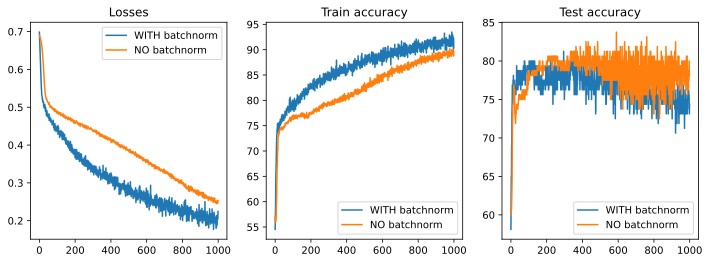

In [8]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(12, 4))

ax[0].plot(lossesWith,label='WITH batchnorm')
ax[0].plot(lossesNo,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith,label='WITH batchnorm')
ax[1].plot(trainAccNo,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAccWith,label='WITH batchnorm')
ax[2].plot(testAccNo,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()

# Additional explorations

In [ ]:
# 1) BatchNorm1d takes several additional inputs, including one called "momentum." You will learn what this parameter
#    means later in this section, but briefly: it is a smoothing parameter that helps stabilize and improve learning
#    weights. The default value is .1. What happens when you change it to .001? How about setting it to zero?
# 
# 2) In the lecture, I said to apply batchnorm to the data *before* applying the nonlinearity (here, relu). This is also
#    implemented in the code above. However, this is discussed in the field and online, and not everyone agrees. Modify 
#    the code to apply batch normalization *after* applying relu. Does that make a big difference? Thinking about the
#    math, which order makes more sense to you? (Don't worry, it's OK to disagree with me!)
# 